In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm  import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn

from pytvision.transforms import transforms as mtrans
from pytvision import visualization as view

sys.path.append('../')
from torchlib.datasets.datasets import ATLASDataset, ATLASExtDataset 

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
pathdata='~/.kaggle/competitions/human-protein-atlas-image-classification'
name_dataset='external_data/data/'

print(pathdata)
print(name_dataset)

~/.kaggle/competitions/human-protein-atlas-image-classification
external_data/data/


In [3]:
def visualizatedataset( data, num=25, imsize=(64,64,3), padding=1 ):    
    """Visualization data set
    Args:
        -data: data loader 
        -num: number of images show
    """
    
    databatch = torch.zeros( [num, imsize[2], imsize[0], imsize[1]], dtype=torch.float32 )
    for i in range(num): 
        idx = np.random.randint( len(data) )
        databatch[i,...] = data[idx][1]   
        
    grid = utils.make_grid( databatch , nrow= int(np.sqrt(num)), normalize=True, padding=padding )       
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

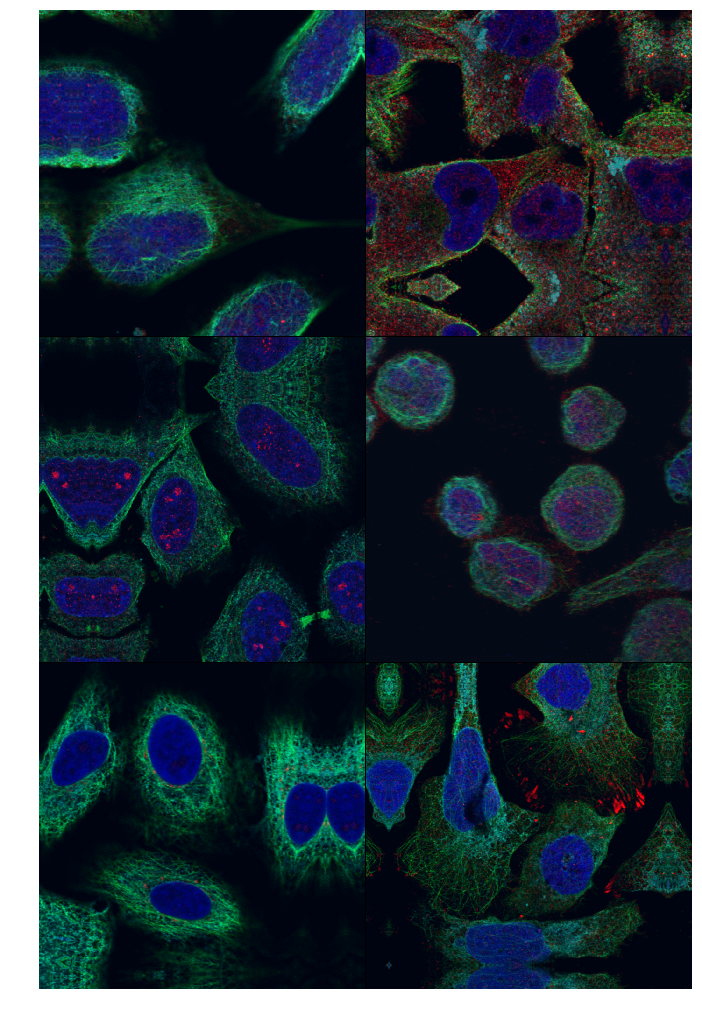

In [12]:

size_input = 1024

# transformations 
normalize = mtrans.ToMeanNormalization(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
# normalize = mtrans.ToNormalization()

transforms_aug = transforms.Compose([
    
    #mtrans.ToResize( (size_input, size_input), resize_mode='square', padding_mode=cv2.BORDER_REFLECT_101 ) ,
    #mtrans.ToResize( (size_input+5, size_input+5), resize_mode='square' ) ,
    mtrans.RandomCrop( (size_input, size_input), limit=0, padding_mode=cv2.BORDER_REFLECT_101  ) , 
    
    mtrans.RandomScale( factor=0.2, padding_mode=cv2.BORDER_REFLECT_101 ), 
    mtrans.ToRandomTransform( mtrans.RandomGeometricalTransform( angle=30, translation=0.2, warp=0.02, padding_mode=cv2.BORDER_REFLECT_101 ), prob=0.5 ),
    mtrans.ToRandomTransform( mtrans.VFlip(), prob=0.5 ),
    mtrans.ToRandomTransform( mtrans.HFlip(), prob=0.5 ),
    #mtrans.RandomElasticDistort( size_grid=64, padding_mode=cv2.BORDER_REFLECT_101 ),
    
    #------------------------------------------------------------------
           
    #mtrans.ToRandomTransform( mtrans.RandomRGBPermutation(), prob=0.30 ),
    mtrans.ToRandomTransform( mtrans.RandomBrightness( factor=0.15 ), prob=0.50 ),
    mtrans.ToRandomTransform( mtrans.RandomContrast( factor=0.15 ), prob=0.50 ),
    mtrans.ToRandomTransform( mtrans.RandomGamma( factor=0.15 ), prob=0.50 ),
    #mtrans.ToRandomTransform( mtrans.RandomHueSaturation( hue_shift_limit=(-5, 5), sat_shift_limit=(-11, 11), val_shift_limit=(-11, 11) ), prob=0.30 ),
    #mtrans.ToRandomTransform( mtrans.ToGrayscale(), prob=0.30 ),
    
    
    #mtrans.RandomRGBPermutation(),
    #mtrans.ToRandomChoiceTransform( [
    #    mtrans.RandomBrightness( factor=0.15 ), 
    #    mtrans.RandomContrast( factor=0.15 ),
    #    #mtrans.RandomSaturation( factor=0.15 ),
    #    mtrans.RandomHueSaturation( hue_shift_limit=(-5, 5), sat_shift_limit=(-11, 11), val_shift_limit=(-11, 11) ),
    #    mtrans.RandomGamma( factor=0.30  ),        
    #    mtrans.ToRandomTransform(mtrans.ToGrayscale(), prob=0.15 ),
    #    ]),    
    
    #mtrans.ToRandomTransform(mtrans.ToGaussianBlur( sigma=0.00001), prob=0.50 ),    
    
    #------------------------------------------------------------------
    mtrans.ToTensor(),
    #mtrans.RandomElasticTensorDistort( size_grid=64, deform=0.005 ),
    normalize,
    ]) 


transforms_det = transforms.Compose([
    #mtrans.ToResize( (size_input, size_input), resize_mode='crop' ) ,
    mtrans.ToResize( (size_input, size_input), resize_mode='square', padding_mode=cv2.BORDER_REFLECT_101 ) ,
    mtrans.ToTensor(),
    normalize,
    ])

dataloader = ATLASDataset(        
    path=pathdata, 
    train=True,
    folders_images='cloud/train_full', 
    metadata='train.csv',
    ext='tif',
    count=100,
    num_channels=3,
    transform=transforms_aug
    )

plt.figure( figsize=(18,18) )
visualizatedataset(dataloader, num=6, imsize=(size_input,size_input,3), padding=1 )
plt.axis('off')
plt.ioff()
plt.show()



In [5]:
print(dataloader.data.path)
print(dataloader.data.folders_images)

/home/fernandez/.kaggle/competitions/human-protein-atlas-image-classification
/cloud/train_full/


In [13]:
512/64


8.0

In [6]:
path = "~/.kaggle/competitions/human-protein-atlas-image-classification" #path competition 
metadata='train.csv' # train.csv, sample_submission.csv
folders_images='train' #train, test
metadata_external='train_external.csv' # train.csv, sample_submission.csv
folders_images_external='train_external' #train, test
train=True #True, False


dataset = ATLASExtDataset(
    path=path, 
    train=train, 
    count=100,
    folders_images=folders_images, 
    metadata=metadata,
    folders_images_external=folders_images_external,
    metadata_external=metadata_external,
    
)
iD,image, prob = dataset[0]

print( len(dataset) )     
print( iD )
print( prob )

105678
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


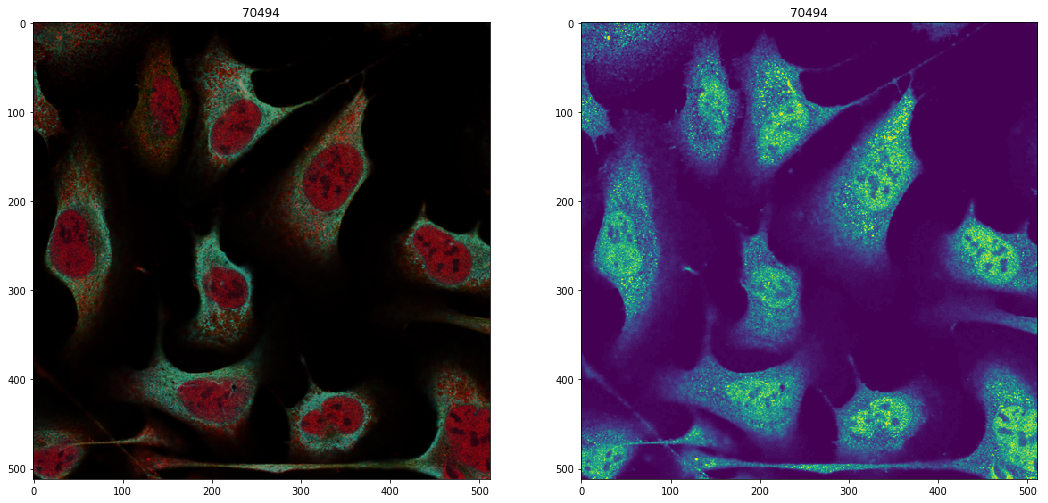

In [7]:

idx = np.random.randint( len(dataset) )
iD, image, prob = dataset[  idx  ]

plt.figure( figsize=(18,18)  )
plt.subplot(121)
plt.imshow(image )
plt.title(idx)
plt.subplot(122)
plt.imshow(image[:,:,0] )
plt.title(idx)
plt.show()

